In [1]:
%matplotlib notebook

In [2]:
import os
import sys
import numpy as np

def get_freer_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A5 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return np.argmax(memory_available)

gpu = get_freer_gpu()
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
print(f'gpu is {gpu}')

import torch
import math
import itertools
from collections import defaultdict
sys.path.append(os.path.abspath(os.path.join('..')))
import cv2
from plenoxels.models.lowrank_video import LowrankVideo
from plenoxels.datasets.video_datasets import Video360Dataset
from plenoxels.ops.image import metrics
import matplotlib.pyplot as plt
%matplotlib inline





gpu is 7


/home/sfk/miniconda3/envs/py38torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Global variables

In [54]:
DATA_DIR = "/home/sfk/data/dnerf/data/jumpingjacks" # "/home/sfk/data/dnerf/data/bouncingballs"   # "/data/DATASETS/VidNerf/flame_salmon"
CHECKPOINT_PATH = '../logs/dnerf_learnedbasis/fixed_jumpingjacks_512_hexsampler_120ksteps_lr0.005/model.pth'

#### Helper functions

In [4]:
def eval_step(data, model, timestamp=None, batch_size=4096):
    """
    Note that here `data` contains a whole image. we need to split it up before tracing
    for memory constraints.
    """
    with torch.cuda.amp.autocast(enabled=True):
        rays_o = data["rays_o"]
        rays_d = data["rays_d"]
        near_far = data["near_far"]
        if timestamp is None:
            timestamp = data["timestamps"]

        if rays_o.ndim == 3:
            rays_o = rays_o.squeeze(0)
            rays_d = rays_d.squeeze(0)

        preds = defaultdict(list)
        for b in range(math.ceil(rays_o.shape[0] / batch_size)):
            rays_o_b = rays_o[b * batch_size: (b + 1) * batch_size].cuda()
            rays_d_b = rays_d[b * batch_size: (b + 1) * batch_size].cuda()
            timestamps_d_b = timestamp.expand(rays_o_b.shape[0]).cuda()

            outputs = model(rays_o_b, rays_d_b, timestamps_d_b, channels={"rgb", "depth"}, 
                            bg_color=torch.tensor([1.0]*3).cuda(),
                            near_far=near_far)
            for k, v in outputs.items():
                if not isinstance(v, list):
                    preds[k].append(v)
    return {k: torch.cat(v, 0) for k, v in preds.items()}

In [5]:
def evaluate_metrics(gt,
                     preds,
                     dset,
                     img_idx: int,
                     name = None):
    img_h, img_w = dset.img_h, dset.img_w
    preds_rgb = (
        preds["rgb"]
        .reshape(img_h, img_w, 3)
        .cpu()
        .clamp(0, 1)
    )
    out_img = preds_rgb
    summary = dict()

    out_depth = None
    if "depth" in preds:
        out_depth = preds['depth'].cpu().reshape(img_h, img_w)[..., None]

    if gt is not None:
        gt = gt.reshape(img_h, img_w, -1).cpu()
        if gt.shape[-1] == 4:
            gt = gt[..., :3] * gt[..., 3:] + (1.0 - gt[..., 3:])
        out_img = torch.cat((out_img, gt), dim=0)

    out_img = (out_img * 255.0).byte().numpy()
    return summary, out_img, out_depth

#### Initialize dataset and model

In [53]:
# dset = Video360Dataset(
#     DATA_DIR, split='test', downsample=2, batch_size=4096,
#     keyframes=False, isg=False, is_contracted=True, is_ndc=False
# )

dset = Video360Dataset(
    DATA_DIR, split='test', downsample=1, batch_size=4096,
    keyframes=False, isg=False, is_contracted=False, is_ndc=False
)

Loading test data: 100%|██████████| 20/20 [00:00<00:00, 98.05it/s]


timestamps are tensor([0.0000, 0.0503, 0.1005, 0.1558, 0.2060, 0.2613, 0.3116, 0.3668, 0.4171,
        0.4724, 0.5226, 0.5779, 0.6281, 0.6834, 0.7337, 0.7889, 0.8392, 0.8945,
        0.9447, 1.0000])


In [55]:
data = torch.load(CHECKPOINT_PATH)

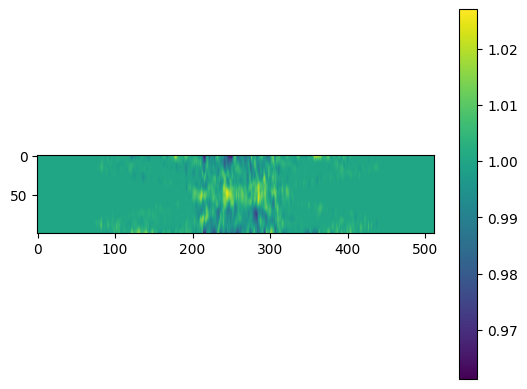

In [56]:
# data['model'].keys()
xt = data['model']['grids.3.2'].cpu()
xt.shape
plt.imshow(torch.mean(xt, dim=1).squeeze())
plt.colorbar()

In [59]:
model = LowrankVideo(
    aabb=torch.tensor([[-1.3, -1.3, -1.3], [1.3, 1.3, 1.3]]),
    len_time=1,
    is_ndc=False,
    is_contracted=False,
    lookup_time=False,
    proposal_sampling=True,
    global_scale=None,
    global_translation=None,
    raymarch_type='fixed',
    single_jitter=False,
    n_intersections=48,
    density_activation='trunc_exp',
    use_F=False,
    sh=False,
    learnedbasis=True,
    density_field_resolution=[128, 256],
    density_field_rank=1,
    num_proposal_samples=[256, 128],
    proposal_feature_dim=10,
    proposal_decoder_type='nn',
    density_model='hexplane',
    multiscale_res=[1, 2, 4, 8],
    grid_config=[
        {
            "input_coordinate_dim": 4,
            "output_coordinate_dim": 64,
            "grid_dimensions": 2,
            "resolution": [64, 64, 64, 100],  #75],
            "rank": 1,
        }
    ],
)


# model = LowrankVideo(
#     aabb=torch.tensor([[-2., -2., -2.], [2., 2., 2.]]),
#     len_time=299,
#     is_ndc=False,
#     is_contracted=True,
#     lookup_time=False,
#     proposal_sampling=True,
#     global_scale=data['model']['spatial_distortion.global_scale'],
#     global_translation=data['model']['spatial_distortion.global_translation'],
#     raymarch_type='fixed',
#     single_jitter=False,
#     n_intersections=48,
#     density_activation='trunc_exp',
#     use_F=False,
#     sh=False,
#     density_field_resolution=[128, 256],
#     density_field_rank=1,
#     num_proposal_samples=[256, 128],
#     proposal_feature_dim=10,
#     proposal_decoder_type='nn',
#     density_model='triplane',
#     multiscale_res=[1, 2, 4],
#     grid_config=[
#         {
#             "input_coordinate_dim": 4,
#             "output_coordinate_dim": 64,
#             "grid_dimensions": 2,
#             "resolution": [84, 64, 64, 150],
#             "rank": 1,
#         }
#     ],
# )

In [60]:
model.load_state_dict(data['model'])
model.cuda();

In [61]:
# store original parameters
parameters = []
for multires_grids in model.grids:
    parameters.append([grid.data for grid in multires_grids])

#### Generate decomposed images

In [62]:
out_no_space = []
out_no_time = []
out_no_space_real = []
out_full = []
with torch.no_grad():
    for img_idx, data in enumerate(dset):
        if not (img_idx in [10, 15]): continue
        print("==> im idx ", img_idx)
        
        # Model without time grids
        for i in range(len(model.grids)):    
            for plane_idx in [2, 4, 5]:  # time-grids off
                model.grids[i][plane_idx].data = torch.ones_like(parameters[i][plane_idx])
            for plane_idx in [0, 1, 3]:  # space-grids on
                model.grids[i][plane_idx].data = parameters[i][plane_idx]
        preds = eval_step(data, model, timestamp=dset.timestamps[img_idx])
        summary, out_img_no_time, out_depth = evaluate_metrics(
            data["imgs"], preds, dset=dset, img_idx=img_idx)
        out_no_time.append(out_img_no_time)
        
        # Model without spatial grids
        for i in range(len(model.grids)):    
            for plane_idx in [2, 4, 5]:  # time-grids on
                model.grids[i][plane_idx].data = parameters[i][plane_idx]
            for plane_idx in [0, 1, 3]:  # space-grids off
                model.grids[i][plane_idx].data = torch.ones_like(parameters[i][plane_idx])
        preds = eval_step(data, model, timestamp=dset.timestamps[img_idx])
        summary, out_img_no_space, out_depth = evaluate_metrics(
            data["imgs"], preds, dset=dset, img_idx=img_idx)
        out_no_space_real.append(out_img_no_space)

        # Full model
        for i in range(len(model.grids)):
            for plane_idx in [0, 1, 3]:  # space-grids on
                model.grids[i][plane_idx].data = parameters[i][plane_idx]
            for plane_idx in [2, 4, 5]:  # time-grids on
                model.grids[i][plane_idx].data = parameters[i][plane_idx]
        preds = eval_step(data, model, timestamp=dset.timestamps[img_idx])
        summary, out_img_full, out_depth = evaluate_metrics(
            data["imgs"], preds, dset=dset, img_idx=img_idx)
        out_img_no_space = (
            out_img_full.astype(float) - out_img_no_time.astype(float)
        ).clip(min=0.0).astype(np.uint8)
        out_no_space.append(out_img_no_space)
        out_full.append(out_img_full)
    
        # break

==> im idx  10
==> im idx  15


#### Plotting

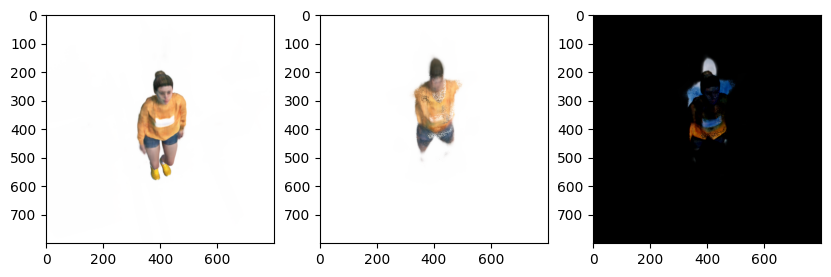

In [65]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow(out_full[0][:800])
ax[2].imshow(out_no_space[0][:800])
ax[1].imshow(out_no_time[0][:800])
# ax[2].imshow(out_full[0][:800] - out_no_time[0][:800])

# ax[0].imshow(out_full[0][:800])
# # ax[2].imshow(out_no_space[0][:800])
# ax[1].imshow(out_no_time[0][:800])
# ax[2].imshow(out_full[0][:800] - out_no_time[0][:800])

# fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
# ax[0].imshow(out_full[1][:800])
# ax[2].imshow(out_no_space[1][:800])
# ax[1].imshow(out_no_time[1][:800])
# ax[2].imshow(out_full[1][:800] - out_no_time[0][:800])

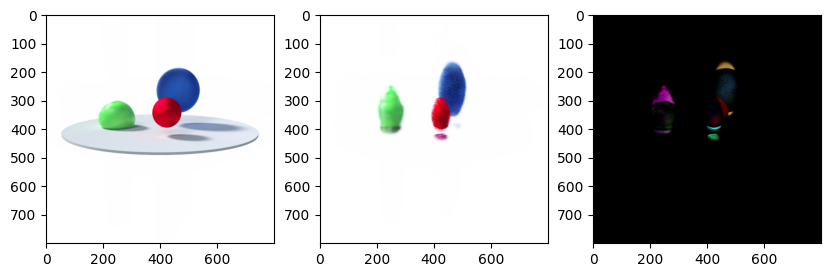

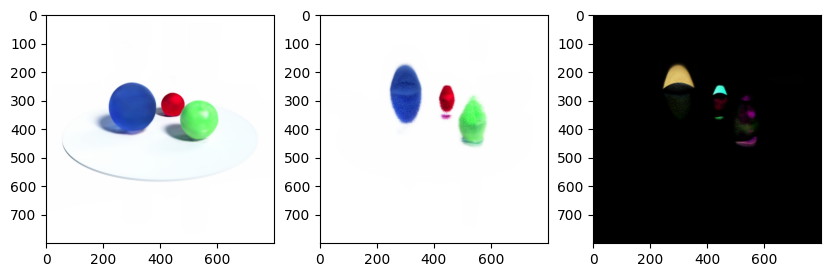

In [36]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow(out_full[0][:800])
ax[2].imshow(out_no_space[0][:800])
ax[1].imshow(out_no_time[0][:800])
# ax[2].imshow(out_full[0][:800] - out_no_time[0][:800])

fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow(out_full[1][:800])
ax[2].imshow(out_no_space[1][:800])
ax[1].imshow(out_no_time[1][:800])
# ax[2].imshow(out_full[1][:800] - out_no_time[0][:800])

# ax[0].imshow(out_full[0][:1014])
# ax[1].imshow(out_no_space[0][:1014])
# ax[2].imshow(out_no_time[0][:1014])